# <span style="color:yellow">Running Analysis</span>

* The person is running on the beach.
* Running is a common form of exercise.
* It can improve cardiovascular function, enhance physical fitness, and relieve stress.
* Running on the beach is more challenging due to the soft sand, which can further enhance the training effect.

# Step 1: Load libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display
import os

# Step 2: Load running video

In [2]:
# Video file path
video_path = "Video/running.mp4"

In [3]:
# Open video file directly
cap = cv2.VideoCapture(video_path)

## Step 2.1: Get detailed video properties

In [4]:
# Get video file size
file_size = os.path.getsize(video_path)
file_size_mb = file_size / (1024 * 1024)  # Convert to MB

In [5]:
fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
duration_sec = frame_count / fps if fps > 0 else 0
duration_min = duration_sec / 60

In [6]:
print(f"Video Properties:")
print(f"  File: {os.path.basename(video_path)}")
print(f"  Size: {file_size_mb:.2f} MB")
print(f"  Dimensions: {width}x{height} pixels")
print(f"  Total frames: {frame_count}")
print(f"  Frame rate: {fps:.1f} FPS")
print(f"  Duration: {duration_min:.1f} min ({duration_sec:.1f} seconds)")

Video Properties:
  File: running.mp4
  Size: 0.50 MB
  Dimensions: 720x576 pixels
  Total frames: 100
  Frame rate: 25.0 FPS
  Duration: 0.1 min (4.0 seconds)


In [7]:
print(f"\nAnalysis plan:")
print(f"  - Will extract up to {frame_count} frames for efficient processing")
print(f"  - Will track movement using optical flow algorithm")
print(f"  - Will highlight motion speed (blue=slow, green=medium, red=fast)")


Analysis plan:
  - Will extract up to 100 frames for efficient processing
  - Will track movement using optical flow algorithm
  - Will highlight motion speed (blue=slow, green=medium, red=fast)


## Step 2.2: Extract frames

In [8]:
# limit to 90 frames for faster processing)
max_frames = 90
frames = []
gray_frames = []

In [9]:
for i in range(min(frame_count, max_frames)):
    ret, frame = cap.read()
    if not ret:
        break
        
    # Resize for consistent processing (adjust if needed)
    frame = cv2.resize(frame, (640, 480))
    frames.append(frame)
    gray_frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))

In [10]:
cap.release()
num_frames = len(frames)
print(f"Extracted {num_frames} frames for analysis")

Extracted 90 frames for analysis


## Step 2.3: Show first frame

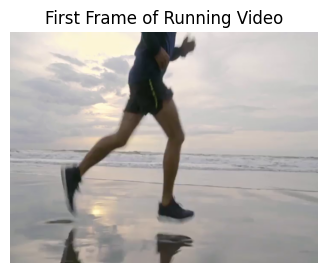

In [11]:
if num_frames > 0:
    plt.figure(figsize=(4, 3))
    plt.imshow(cv2.cvtColor(frames[0], cv2.COLOR_BGR2RGB))
    plt.title("First Frame of Running Video")
    plt.axis('off')
    plt.show()

# Step 3: Track motion with optical flow

## Step 3.1: Configure feature detection parameters

In [12]:
# Feature detection parameters (optimized for human movement)
feature_params = dict(
    maxCorners=150,        # More features for detailed movement
    qualityLevel=0.03,     # Lower to detect more features on clothing
    minDistance=10,        # Avoid clustered features
    blockSize=15
)

## Step 3.2: Detect initial tracking features

In [13]:
p0 = cv2.goodFeaturesToTrack(gray_frames[0], mask=None, **feature_params)
p0 = p0.astype(np.float32)
print(f"Detected {len(p0)} motion-tracking points")

Detected 99 motion-tracking points


## Step 3.3: Lucas-Kanade parameters

In [14]:
lk_params = dict(
    winSize=(25, 25),      # Larger window for tracking limbs
    maxLevel=3,
    criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01)
)

## Step 3.4: Initialize tracking variables

In [15]:
# Prepare storage and initial values for tracking
tracked_frames = []
p_prev = p0
gray_prev = gray_frames[0]

## Step 3.5: Process frames with optical flow

In [16]:
# Track features through each frame
for i in range(1, num_frames):
    gray_curr = gray_frames[i]
    
    # Calculate optical flow
    p_curr, status, err = cv2.calcOpticalFlowPyrLK(
        gray_prev, gray_curr, p_prev, None,** lk_params
    )
    
    # Keep only good tracks
    good_new = p_curr[status == 1]
    good_old = p_prev[status == 1]
    
    # Draw motion vectors (color-coded by speed)
    frame = frames[i].copy()
    for new, old in zip(good_new, good_old):
        a, b = new.ravel()
        c, d = old.ravel()
        
        # Calculate motion speed
        dx = a - c
        dy = b - d
        speed = np.sqrt(dx**2 + dy**2)
        
        # Color code: blue (slow) → green → red (fast)
        if speed < 2:
            color = (255, 0, 0)    # Blue
        elif speed < 5:
            color = (0, 255, 0)    # Green
        else:
            color = (0, 0, 255)    # Red
            
        # Draw flow vector
        frame = cv2.arrowedLine(
            frame, (int(c), int(d)), (int(a), int(b)),
            color, 2, tipLength=0.3
        )
    
    tracked_frames.append(frame)
    
    # Update for next frame
    p_prev = good_new.reshape(-1, 1, 2)
    gray_prev = gray_curr

# Step 4: Create and Display Animation

## Step 4.1: Define animation update function

In [17]:
def update(frame):
    plt.cla()
    img = cv2.cvtColor(tracked_frames[frame], cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(f"Running Motion Analysis - Frame {frame+1}\n(Red = Fast Movement, Blue = Slow Movement)")
    plt.axis('off')
    return []

## Step 4.2: Configure, create, and display animation

In [18]:
# Create animation
plt.close('all')
fig = plt.figure(figsize=(7, 5))
ani = animation.FuncAnimation(
    fig, update,
    frames=range(len(tracked_frames)),
    interval=1000/fps,  # Match original video speed
    blit=True,
    repeat=True
)

# Display animation
display(HTML(ani.to_html5_video()))

# Optional: Save animation
ani.save('Video/Running_Analysis.mp4', fps=fps)
print("Saved analysis to 'Running_Analysis.mp4'")

# Optional: Explicitly prevent additional plot rendering
plt.close(fig)

Saved analysis to 'Running_Analysis.mp4'
